<a href="https://colab.research.google.com/github/katelyn-hucker/xai_hw6/blob/main/Mechanistic_Interpretability_Code_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import sys
from diffusers import DiffusionPipeline, KandinskyPipeline, KandinskyPriorPipeline
import torch
import PIL
import torch
from diffusers.utils import load_image
from torchvision import transforms
from transformers import CLIPVisionModelWithProjection
from diffusers.models import UNet2DConditionModel
import numpy as np
import os
import importlib.util
import huggingface_hub
import torch
import os
import importlib.util
from diffusers import (
    KandinskyPriorPipeline,
    KandinskyPipeline,
)

# Set device and default dtype
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float32)  # Ensure base dtype is float32

def load_kadinsky():
    prior = KandinskyPriorPipeline.from_pretrained(
        'kandinsky-community/kandinsky-2-1-prior',
        torch_dtype=torch.float16
    ).to(DEVICE)

    decoder = KandinskyPipeline.from_pretrained(
        'kandinsky-community/kandinsky-2-1',
        torch_dtype=torch.float16
    ).to(DEVICE)

    # Get zero embedding for negative prompt
    zero_embed = torch.zeros(1, prior.image_encoder.config.projection_dim).to(DEVICE)

    return prior, decoder, zero_embed

def load_sae():
    from huggingface_hub import snapshot_download
    model_file_path = snapshot_download(repo_id="gytdau/clip-sae-128")

    model_py_path = os.path.join(model_file_path, "model.py")
    weights_path = os.path.join(model_file_path, "sparse_autoencoder_128.pth")

    spec = importlib.util.spec_from_file_location("model_module", model_py_path)
    model_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(model_module)

    SparseAutoencoder = getattr(model_module, "SparseAutoencoder")

    # Update dimensions to match pretrained weights
    embedding_dim = 1280
    hidden_dim = 163840  # This matches the pretrained model

    model = SparseAutoencoder(embedding_dim, hidden_dim)

    state_dict = torch.load(weights_path, map_location=torch.device('cuda'))
    model.half()
    model.load_state_dict(state_dict)
    model.eval()
    model.to("cuda")

    return model

In [97]:
prior, decoder, negative_emb = load_kadinsky()
model = load_sae()

image_encoder%2Fconfig.json:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.69G [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.01G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)age_processor%2Fpreprocessor_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

prior%2Fconfig.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.10G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/250 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/317 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/271M [00:00<?, ?B/s]

movq%2Fconfig.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-96-aa025fc64acb>:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=torch.device('cuda'))


In [98]:

def get_error(embed):
    encoded = model.encode(embed)
    decoded = model.decode(encoded)
    error = embed - decoded
    return error

def embed_image(item):
    return prior.interpolate([item], [1]).image_embeds[0]

def generate_one(image_embeds):
    generator = torch.Generator("cuda")
    generator.manual_seed(1)
    images = decoder(
        image_embeds=image_embeds.unsqueeze(0),
        negative_image_embeds=negative_emb,
        height=512,
        width=512,
        num_inference_steps=18,
        num_images_per_prompt=1,
        generator=generator,
    ).images

    return images[0]

def print_top_10(features):
    top_10 = features.argsort()[-10:]
    top_10 = reversed(top_10)

    for idx in top_10:
        print(f"Feature {idx:10d} = {features[idx]:.2f} (https://www.featurelab.xyz/features/{idx})")


In [92]:
# Initialize models
prior, decoder, negative_emb = load_kadinsky()
model = load_sae()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You are using a model of type xlm-roberta to instantiate a model of type M-CLIP. This is not supported for all configurations of models and can yield errors.


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-91-2614e876d46a>:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=torch.device('cuda'))


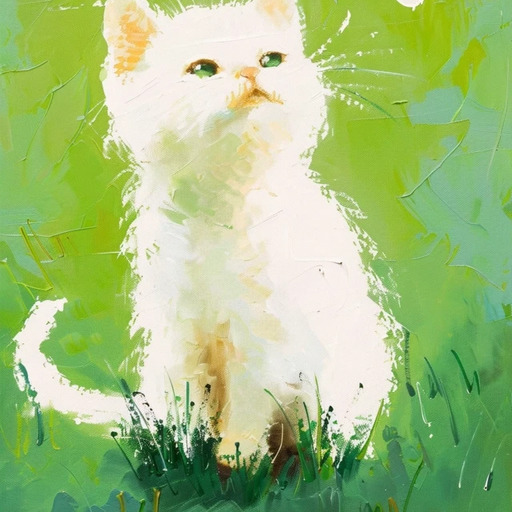

In [67]:
from diffusers.utils import load_image
img = load_image("https://images.featurelab.xyz/example_2.jpg")
img

In [99]:
embed = embed_image(img)

  0%|          | 0/25 [00:00<?, ?it/s]

In [100]:
embed.shape

torch.Size([1280])

In [102]:
features=model.encode(embed)

In [103]:
print("Found these features:")
print_top_10(features)

Found these features:
Feature      35430 = 15.52 (https://www.featurelab.xyz/features/35430)
Feature     107198 = 15.25 (https://www.featurelab.xyz/features/107198)
Feature       1893 = 15.03 (https://www.featurelab.xyz/features/1893)
Feature      40216 = 14.80 (https://www.featurelab.xyz/features/40216)
Feature      22603 = 14.77 (https://www.featurelab.xyz/features/22603)
Feature     145260 = 14.73 (https://www.featurelab.xyz/features/145260)
Feature     147072 = 14.44 (https://www.featurelab.xyz/features/147072)
Feature      62695 = 13.45 (https://www.featurelab.xyz/features/62695)
Feature      42287 = 12.89 (https://www.featurelab.xyz/features/42287)
Feature     112466 = 12.80 (https://www.featurelab.xyz/features/112466)


  0%|          | 0/18 [00:00<?, ?it/s]

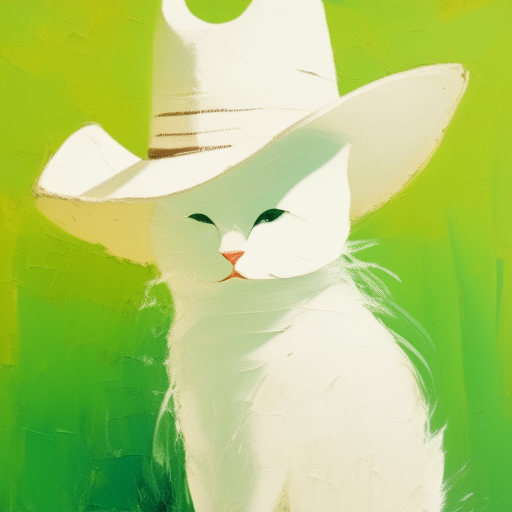

In [104]:
features[147026] = 20


generate_one(model.decode(features) + get_error(embed))

##

opt


In [ ]:
def load_kadinsky():
    prior = KandinskyPriorPipeline.from_pretrained(
        'kandinsky-community/kandinsky-2-1-prior',
        torch_dtype=torch.float16
    ).to(DEVICE)

    decoder = KandinskyPipeline.from_pretrained(
        'kandinsky-community/kandinsky-2-1',
        torch_dtype=torch.float16
    ).to(DEVICE)

    # Get zero embedding for negative prompt
    zero_embed = torch.zeros(1, prior.image_encoder.config.projection_dim).to(DEVICE)

    return prior, decoder, zero_embed

def load_sae():
    from huggingface_hub import snapshot_download
    model_file_path = snapshot_download(repo_id="gytdau/clip-sae-128")

    model_py_path = os.path.join(model_file_path, "model.py")
    weights_path = os.path.join(model_file_path, "sparse_autoencoder_128.pth")

    spec = importlib.util.spec_from_file_location("model_module", model_py_path)
    model_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(model_module)

    SparseAutoencoder = getattr(model_module, "SparseAutoencoder")

    # Update dimensions to match pretrained weights
    embedding_dim = 1280
    hidden_dim = 163840  # This matches the pretrained model

    model = SparseAutoencoder(embedding_dim, hidden_dim)

    state_dict = torch.load(weights_path, map_location=torch.device('cuda'))
    model.half()
    model.load_state_dict(state_dict)
    model.eval()
    model.to("cuda")

    return model

### Intervention Experiments

The paper notes that as intervention value
1) Intervention Value Feature Increase Degrades The Image Quality
